# Firestore to ML Engine

The following notebook shows you how to read data from Cloud Firestore, clean it with Pandas, and train it with Scikit Learn. 

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import choice, randint
import matplotlib.pyplot as plt

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate('service-account.json')
app = firebase_admin.initialize_app(cred)
db = firestore.client()

print('initialized')

# Firestore Write and Read Data

For this demo, we are writing some synthentic random data about app developers. Devs who use Firebase and a good programming language have a better chance of being happy.  

In [ ]:
devs = db.collection('developers')

In [ ]:
# Optional: Seed the Database

languages = { 
  u'python': 50, 
  u'rust': 25, 
  u'typescript': 10, 
  u'javascript': 0,
  u'coffescript': -10,
  u'elm': -2,
  u'cobol': -50
}


for i in range(0, 200):
    dev = {
        'firebase': randint(0, 2),
        'language': choice(list(languages.keys())),
        'age': randint(10, 99)
      }
  
    r = randint(-25, 25)
    dev['happiness'] = r + languages[dev['language']] + (25 if dev['firebase'] else -25)
  
    devs.add(dev)
    


In [ ]:
docs = devs.get()
data = []
for doc in docs:
    data.append(doc.to_dict())
    df = pd.DataFrame(data)
    
df.to_csv('data.csv', index=False)

## Exploratory Analysis

In [4]:
df = pd.read_csv('data.csv')
df.sample(10)

,age,firebase,happiness,language
477,56,1,44,rust
24,89,1,-32,elm
555,71,0,-56,typescript
166,55,1,26,javascript
199,20,1,70,python
412,89,1,55,python
492,47,0,-55,cobol
162,43,0,-12,elm
558,76,0,11,rust
644,80,1,69,rust


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


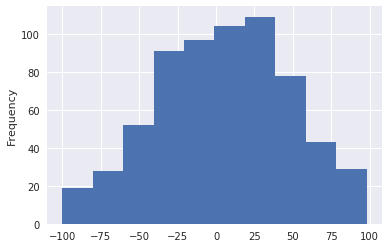

In [5]:
df['happiness'].plot.hist()

In [6]:
df.describe()

,age,firebase,happiness
count,650.000000,650.000000,650.000000
mean,54.341538,0.526154,4.649231
std,25.462809,0.499700,42.935829
min,10.000000,0.000000,-100.000000
25%,32.000000,0.000000,-26.000000
50%,56.000000,1.000000,4.500000
75%,76.000000,1.000000,36.000000
max,98.000000,1.000000,98.000000


# Data Cleaning

Transform data into optimal format for ML

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['language'] = le.fit_transform(df['language'])
le.classes_

array(['cobol', 'coffescript', 'elm', 'javascript', 'python', 'rust',
       'typescript'], dtype=object)

In [8]:
df.sample(5)

,age,firebase,happiness,language
4,95,1,43,5
220,92,0,18,5
589,22,0,-32,1
17,53,1,78,4
46,33,1,90,5


In [9]:



x = df.drop(labels='happiness', axis=1)
y = df['happiness']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

X_train.head()

,age,firebase,language
25,48,0,4
364,26,1,2
507,83,0,2
140,46,0,0
48,11,0,2


## Train a Random Forest Model

Now it's time for the fun part. We train the Random Forest Regressor model and analyze the predictions on the test (y) split data. 

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(max_depth=3, random_state=23, n_estimators=500)
model.fit(x, y)

preds = model.predict(X_test)

print("Model Mean Abosolute Error MAE {}".format(mean_absolute_error(y_test, preds)))

Model Mean Abosolute Error MAE 18.0512780528


In [11]:
randos = randint(-100, high=100, size=len(y_test))

print("Random Predictions MAE {}".format(mean_absolute_error(y_test, randos)))

Random Predictions MAE 56.0697674419


## Analyze Feature Importance

How important was each feature? As expected, Firebase accounts for 60% of the weight, language for 40%, and age < 1%. 

In [12]:
pd.DataFrame(data=[model.feature_importances_], columns=x.columns)

,age,firebase,language
0,0.00813,0.555556,0.436315


## Final Sanity Check

Let's make sure it makes a reasonable prediction for a happy and sad developer. 

In [13]:
happy = np.array([[23, 1, 4]])
model.predict(happy)

array([61.897288])

In [14]:
sad = np.array([[23, 0, 0]])
model.predict(sad)

array([-63.44628183])

## Export Model for ML Engine

Our final step is to exort the model to ML engine.

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, 'model.joblib')

In [ ]:
from firebase_admin import storage
bucket = storage.bucket(name='angularfirebase-267db.appspot.com')

In [ ]:
b = bucket.blob('happy-v1/model.joblib')
b.upload_from_filename('model.joblib')
print('model uploaded!')